# Packages

In [111]:
import torch,os,tqdm,importlib,warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from zipfile import ZipFile
import tool.sodt_utils as sodt_utils
import tool.evaluator as lhtevaluator
warnings.filterwarnings("ignore")

In [104]:
importlib.reload(sodt_utils)
importlib.reload(lhtevaluator)

<module 'tool.evaluator' from '/home/hxl170008/code/git_repos/SODT_Deer/tool/evaluator.py'>

# unzip dataset 'NDT_Deer.zip'
- please download ['NDT_Deer.zip'](https://utdallas.app.box.com/file/1301463614054?s=biyodywd89tteyposrmte994k3x6tnu7&sb=/activity) to the folder 'data'
- unzip the zip file.

In [17]:
p = r"data/NDT_Deer.zip"
with ZipFile(p,'r') as zObject:
    zObject.extractall(path=r"data")

# Dataset Architecture
- |-NDT_Deer
    - |-Annotations # store all annotation files (.txt). annotation format: [label,xmin,ymin,xmax,ymax]
    - |-JPGImages # store all jpg files
    - |-Test
        - |-anns.txt
        - |-imgs.txt
    - |-Train
        - |-anns.txt
        - |-imgs.txt

# Dataset Configure

- small object: $area \le 187$
- medium object: $187< area \le 408$
- large: $area > 408$

In [58]:
class Config:
    root = r'data/NDT_Deer' # 
    img_path = r'data/NDT_Deer/JPGImages/0'
    ann_path = r'data/NDT_Deer/Annotations'
    pretrained = "pretrained"
    areaRng = [[0, 10000000000.0], [0,187],[187.5,405],[408,10000000000.0]]
#
opt = Config()

#  Distribution of BBox Areas and Num objects per image

In [12]:
fp1 = os.path.join(opt.root, 'Train','imgs.txt')
fp2 = os.path.join(opt.root, 'Train','anns.txt')
trainImgs = np.loadtxt(fp1,dtype=str)
trainAnns = np.loadtxt(fp2,dtype=str)
#
fp1 = os.path.join(opt.root, 'Test','imgs.txt')
fp2 = os.path.join(opt.root, 'Test','anns.txt')
testImgs = np.loadtxt(fp1,dtype=str)
testAnns = np.loadtxt(fp2,dtype=str)
#
images = trainImgs.tolist() + testImgs.tolist()
annotations = trainAnns.tolist() + testAnns.tolist()
imgDS = sodt_utils.BBoxDataset(root=opt.root,imgs=images,anns=annotations,transform=sodt_utils.get_transform())
areas = []
numPerImg = []
if hasattr(tqdm,'notebook'):
    pr = tqdm.notebook.trange(len(imgDS))
else:
    pr = tqdm.tqdm_notebook(range(len(imgDS)))
for i in pr:
    _,tgt = imgDS[i]
    a = tgt['area']
    b = tgt['boxes'].numpy()
    numPerImg.append(len(a))
    for bbid,j in enumerate(range(len(a))):
        areas.append(a[j].item())
    #
    

100%|██████████████████████████████████████████████████████████████████████████| 2277/2277 [00:12<00:00, 176.09it/s]


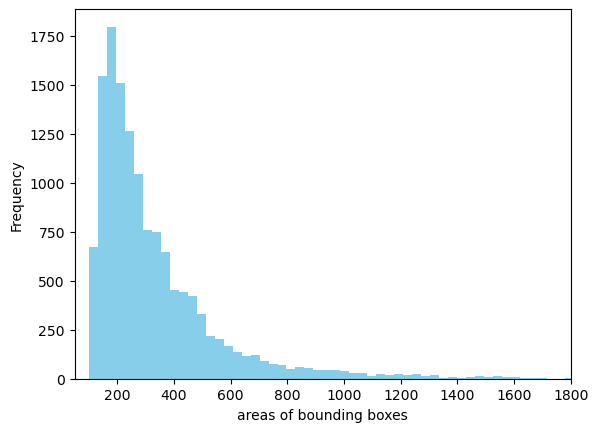

In [13]:
fig, ax = plt.subplots(1,1)
ax.hist(areas, bins=100, color='skyblue')
ax.set_xlabel('areas of bounding boxes')
ax.set_ylabel('Frequency')
ax.set_xlim([50,1800])
plt.show()

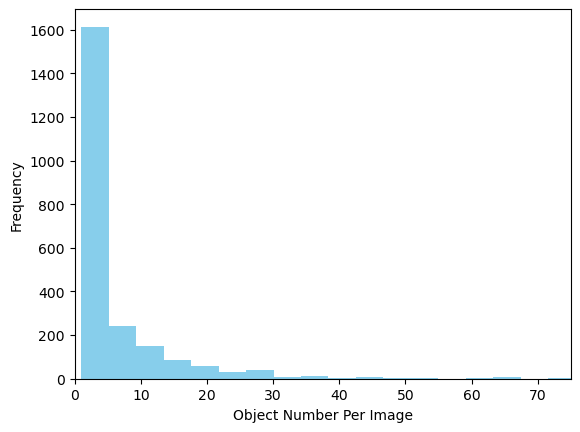

In [14]:
fig, ax = plt.subplots(1,1)
ax.hist(numPerImg,bins=20, color='skyblue')
ax.set_xlabel('Object Number Per Image')
ax.set_ylabel('Frequency')
ax.set_xlim([0,75])
plt.show()

# Dataset Construction for training and testing

In [5]:
fp1 = os.path.join(opt.root, 'Train','imgs.txt')
fp2 = os.path.join(opt.root, 'Train','anns.txt')
trainImgs = np.loadtxt(fp1,dtype=str)
trainAnns = np.loadtxt(fp2,dtype=str)
#
fp1 = os.path.join(opt.root, 'Test','imgs.txt')
fp2 = os.path.join(opt.root, 'Test','anns.txt')
testImgs = np.loadtxt(fp1,dtype=str)
testAnns = np.loadtxt(fp2,dtype=str)
#
trainDS = sodt_utils.BBoxDataset(root=opt.root,imgs=trainImgs,anns=trainAnns,transform=sodt_utils.get_transform())
testDS  = sodt_utils.BBoxDataset(root=opt.root,imgs=testImgs,anns=testAnns, transform=sodt_utils.get_transform())
#
train_loader = torch.utils.data.DataLoader(trainDS,batch_size=5,shuffle=True, num_workers=4, collate_fn=sodt_utils.collate_fn)
test_loader  = torch.utils.data.DataLoader(testDS,batch_size=5,shuffle=False, num_workers=2, collate_fn=sodt_utils.collate_fn)
f'train:{len(trainDS)}, test: {len(testDS)}'

'train:1833, test: 444'

# Model Construction

- M1: FPN based on ResNet152 + small anchor box ($4^{2}$,$8^{2}$,$16^{2}$,$32^{2}$,$64^{2}$,) + RoI 8x10
- M2: VGG16 + big anchor box ($128^{2}$,$256^{2}$,$512^{2}$) + RoI 7x7
- M3: FPN based on ResNet152 + big anchor box ($128^{2}$,$256^{2}$,$512^{2}$) + RoI 8x10
- M4: FPN based on ResNet152 + small anchor box ($4^{2}$,$8^{2}$,$16^{2}$,$32^{2}$,$64^{2}$,) + RoI 7x7

In [6]:
M1 = sodt_utils.constructModel(name='M1')
M2 = sodt_utils.constructModel(name='M2')
M3 = sodt_utils.constructModel(name='M3')
M4 = sodt_utils.constructModel(name='M4')

# Example of training a model

In [40]:
M1 = sodt_utils.constructModel(name='M1')
device = torch.device("cuda")
M1.to(device)
epoch=1
params = [p for p in M1.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.0001)
optimizer = torch.optim.Adam(params, lr=0.0001)
logger=sodt_utils.lht_train_one_epoch(M1,optimizer,train_loader,device,epoch,print_freq=len(train_loader),warm=False)

  0%|▏                                                                              | 1/367 [00:00<03:17,  1.86it/s]

Epoch: [1] [  0/367] eta: 0:03:18 lr: 0.000100 loss: 17169932.0000 (17169932.0000) time: 0.5412 data: 0.2627 max mem: 15128


Epoch: [1] [366/367] eta: 0:00:00 lr: 0.000100 loss: 1.3826 (74567.7201) time: 0.3445 data: 0.0121 max mem: 16754
Epoch: [1] Total time: 0:02:13 (0.3634 s / it)


# download pretrained weight files (.cpkt)
- click [cfg.zip](https://utdallas.box.com/s/xvea3i1knqis9ua2ml7u1fyoj5jlz7p9) to download file to the folder 'pretrained'
- run the following cell to unzip 'cfg.zip'

In [54]:
p = r"pretrained/cfg.zip"
with ZipFile(p,'r') as zObject:
    zObject.extractall(path=r"pretrained")

In [7]:
M1.load_state_dict(torch.load(r'pretrained/cfg/m1.ckpt'))
M1 = M1.cpu()
M2.load_state_dict(torch.load(r'pretrained/cfg/m2.ckpt'))
M2 = M2.cpu()
M3.load_state_dict(torch.load(r'pretrained/cfg/m3.ckpt'))
M3 = M3.cpu()
M4.load_state_dict(torch.load(r'pretrained/cfg/m4.ckpt'))
M4 = M4.cpu()

In [14]:
device = torch.device("cuda")
M1.to(device)
coco_evaluator = lhtevaluator.lht_get_coco_evaluator(M1,test_loader,device=device,areaRng=opt.areaRng)
s = lhtevaluator.lht_get_coco_stats(coco_evaluator)
s

creating index...
index created!


100%|███████████████████████████████████████████████████████████████████████████████| 89/89 [00:13<00:00,  6.70it/s]

Accumulating evaluation results...
DONE (t=0.06s).


array([0.41130022, 0.86416022, 0.28045842, 0.2881115 , 0.41103249,
       0.4886601 , 0.10259445, 0.39517524, 0.5164315 , 0.42739965,
       0.53695652, 0.56584967])

# Generate COCO Evaluation Matrix 

In [105]:
ret_m1 = sodt_utils.getAPSmallMediumBig(model=M1,testAnns=testAnns, testImgs=testImgs, root=opt.root, areaRng=opt.areaRng)
ret_m2 = sodt_utils.getAPSmallMediumBig(model=M2,testAnns=testAnns, testImgs=testImgs, root=opt.root, areaRng=opt.areaRng)
ret_m3 = sodt_utils.getAPSmallMediumBig(model=M3,testAnns=testAnns, testImgs=testImgs, root=opt.root, areaRng=opt.areaRng)
ret_m4 = sodt_utils.getAPSmallMediumBig(model=M4,testAnns=testAnns, testImgs=testImgs, root=opt.root, areaRng=opt.areaRng)

  0%|          | 0/444 [00:00<?, ?it/s]

creating index...
index created!


  0%|          | 0/22 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/42 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.03s).
creating index...
index created!


  0%|          | 0/26 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/89 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.06s).


  0%|          | 0/444 [00:00<?, ?it/s]

creating index...
index created!


  0%|          | 0/22 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/42 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.03s).
creating index...
index created!


  0%|          | 0/26 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/89 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.06s).


  0%|          | 0/444 [00:00<?, ?it/s]

creating index...
index created!


  0%|          | 0/22 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/42 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.03s).
creating index...
index created!


  0%|          | 0/26 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/89 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.06s).


  0%|          | 0/444 [00:00<?, ?it/s]

creating index...
index created!


  0%|          | 0/22 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/42 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.03s).
creating index...
index created!


  0%|          | 0/26 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.02s).
creating index...
index created!


  0%|          | 0/89 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.06s).


In [109]:
df = pd.DataFrame()
df['COCO_index'] = list(ret_m1.keys())
df['M1'] = list(ret_m1.values())
df['M2'] = list(ret_m2.values())
df['M3'] = list(ret_m3.values())
df['M4'] = list(ret_m4.values())
df.set_index('COCO_index', inplace=True)
df

M1        M2        M3        M4
COCO_index                                                
AP_0.5_all          0.864160  0.713585  0.774138  0.845781
AP_0.5_small        0.673440  0.471524  0.549956  0.647315
AP_0.5_medium       0.914430  0.739488  0.834658  0.903832
AP_0.5_large        0.918712  0.870206  0.862010  0.894451
AP_0.5:0.95_small   0.288111  0.156273  0.225567  0.275319
AP_0.5:0.95_medium  0.411032  0.293185  0.367936  0.402307
AP_0.5:0.95_large   0.488660  0.447014  0.473557  0.475935
AR_0.5:0.95_small   0.427400  0.225305  0.315009  0.425480
AR_0.5:0.95_medium  0.536957  0.411067  0.484091  0.532312
AR_0.5:0.95_large   0.565850  0.512745  0.541993  0.542484

# small object detection

## 4 deer objects

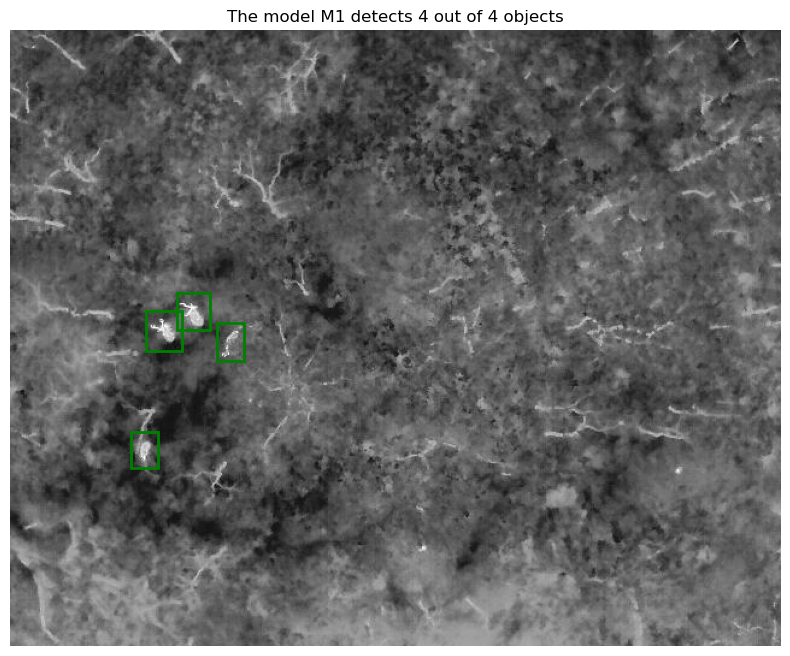

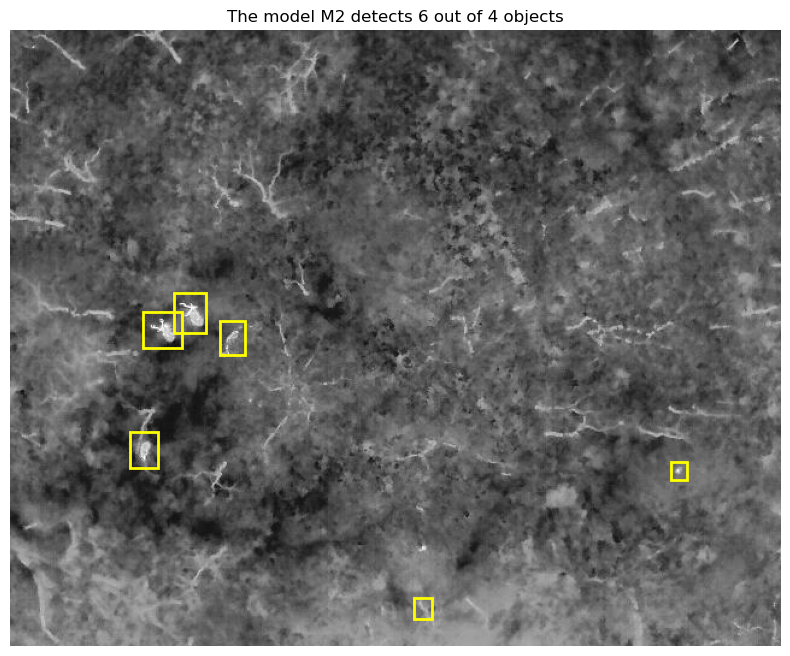

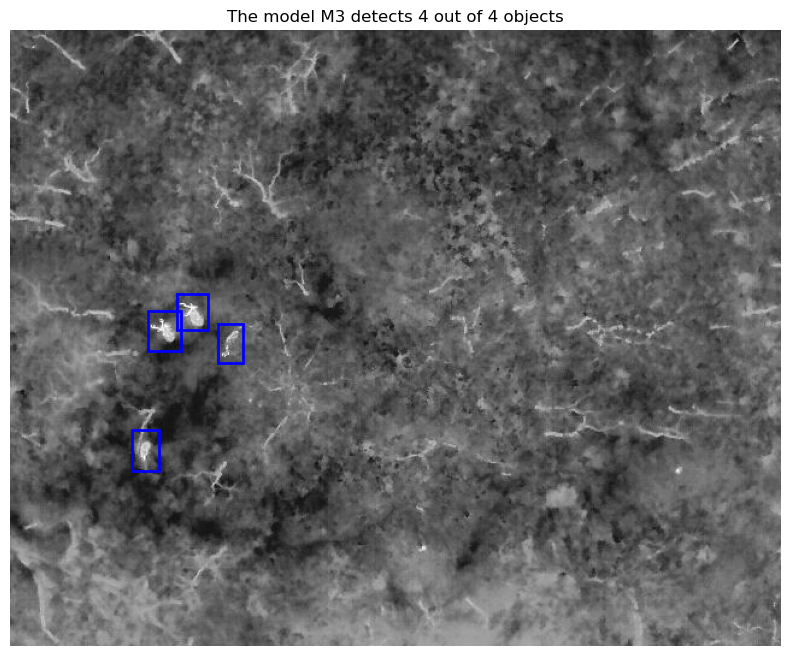

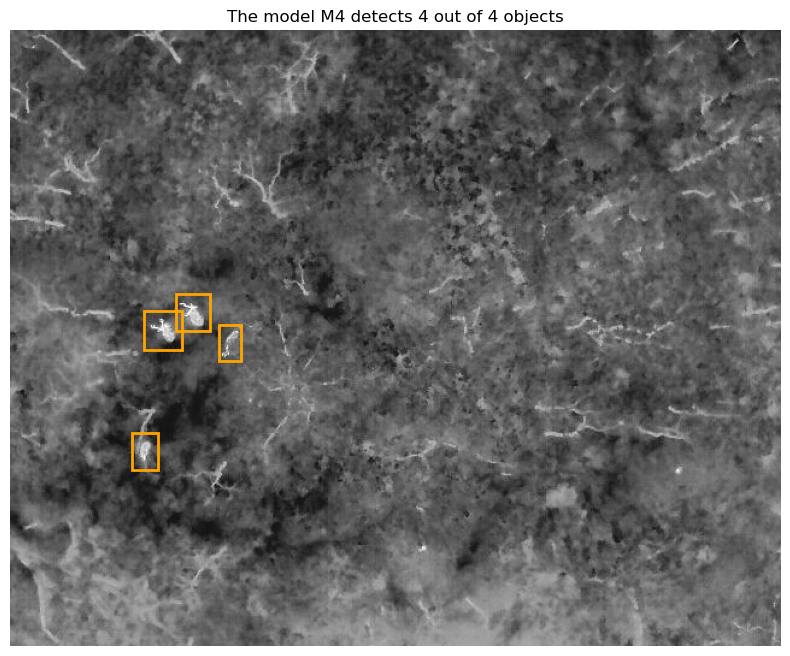

In [98]:
p = r'testImages/4.JPG'
img, pred = sodt_utils.smallObjDetection(M1,p)
boxes = pred['boxes']
boxes = boxes.detach().cpu().numpy()
img = img.numpy()
ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='green',figsize=(10,8))
ax.set_title(f'The model M1 detects {boxes.shape[0]} out of 4 objects')
ax.set_axis_off()
# M2
img, pred = sodt_utils.smallObjDetection(M2,p)
boxes = pred['boxes']
boxes = boxes.detach().cpu().numpy()
img = img.numpy()
ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='yellow',figsize=(10,8))
ax.set_title(f'The model M2 detects {boxes.shape[0]} out of 4 objects')
ax.set_axis_off()
# M3
img, pred = sodt_utils.smallObjDetection(M3,p)
boxes = pred['boxes']
boxes = boxes.detach().cpu().numpy()
img = img.numpy()
ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='blue',figsize=(10,8))
ax.set_title(f'The model M3 detects {boxes.shape[0]} out of 4 objects')
ax.set_axis_off()
#
img, pred = sodt_utils.smallObjDetection(M4,p)
boxes = pred['boxes']
boxes = boxes.detach().cpu().numpy()
img = img.numpy()
ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='orange',figsize=(10,8))
ax.set_title(f'The model M4 detects {boxes.shape[0]} out of 4 objects')
ax.set_axis_off()

## 73 deer objects

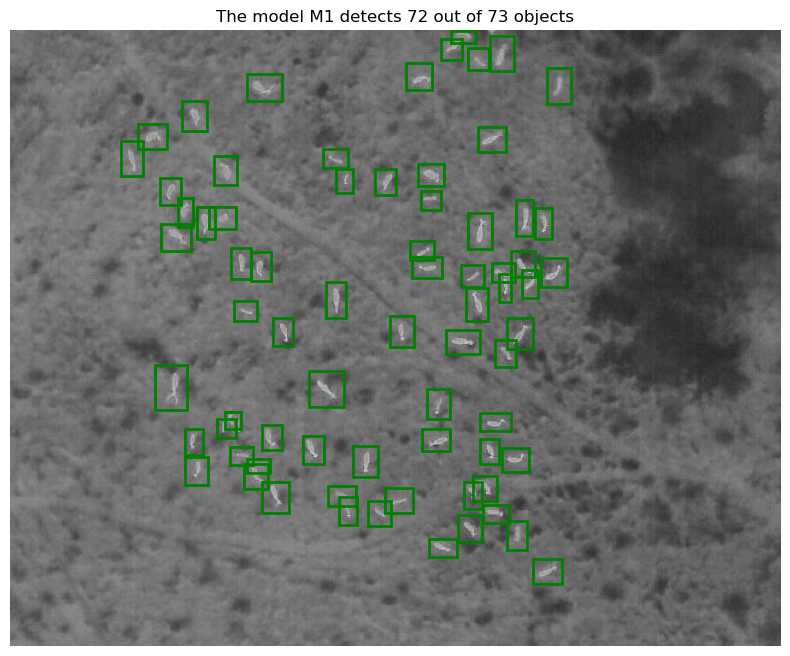

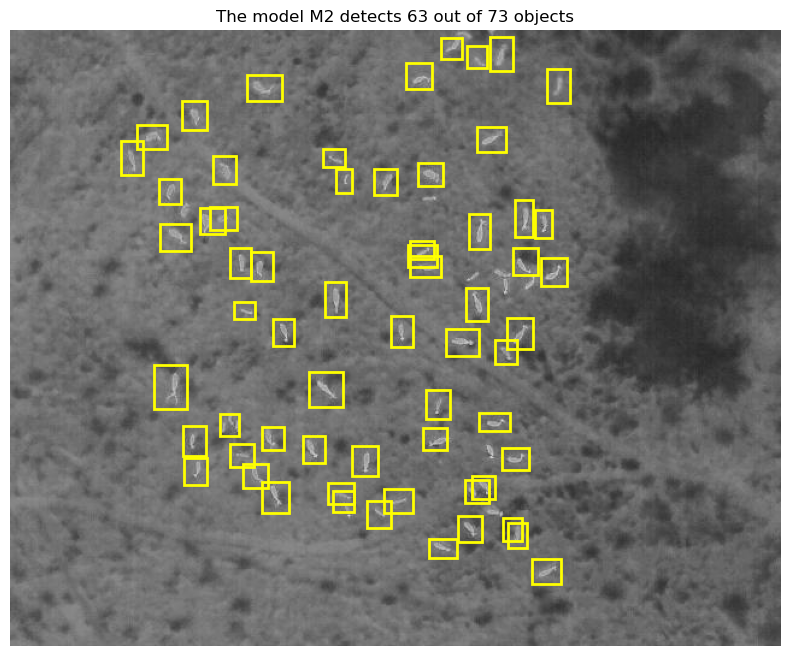

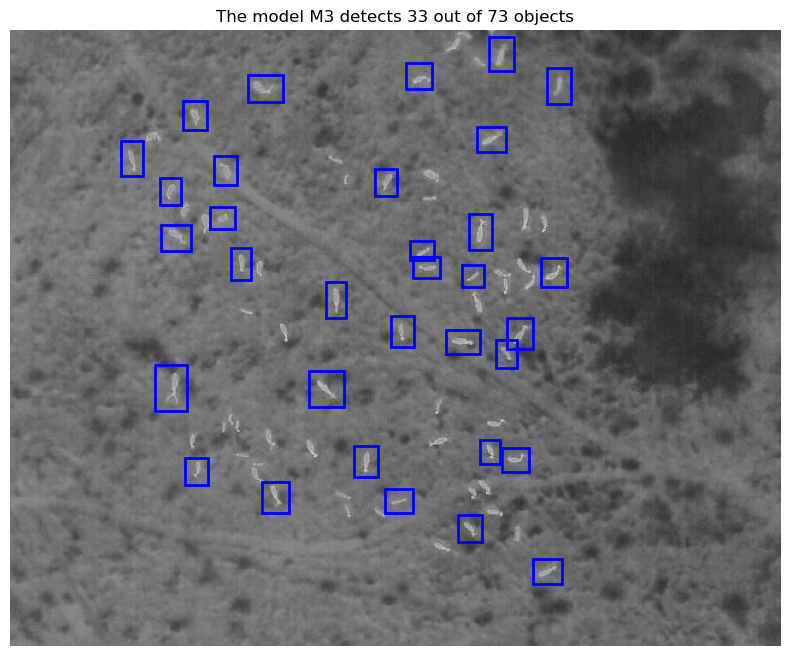

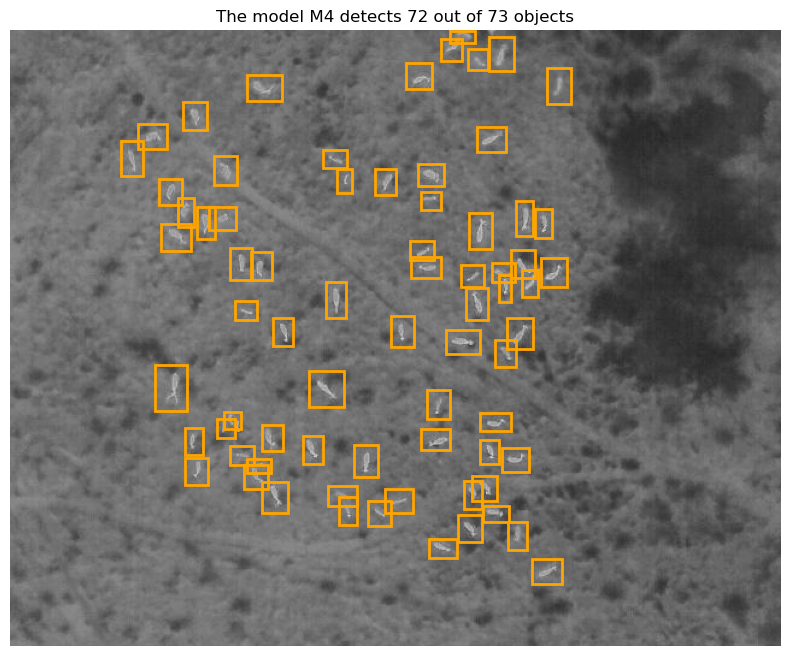

In [100]:
p = r'testImages/73.JPG'
img, pred = sodt_utils.smallObjDetection(M1,p)
boxes = pred['boxes']
boxes = boxes.detach().cpu().numpy()
img = img.numpy()
ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='green',figsize=(10,8))
ax.set_title(f'The model M1 detects {boxes.shape[0]} out of 73 objects')
ax.set_axis_off()
# M2
img, pred = sodt_utils.smallObjDetection(M2,p)
boxes = pred['boxes']
boxes = boxes.detach().cpu().numpy()
img = img.numpy()
ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='yellow',figsize=(10,8))
ax.set_title(f'The model M2 detects {boxes.shape[0]} out of 73 objects')
ax.set_axis_off()
# M3
img, pred = sodt_utils.smallObjDetection(M3,p)
boxes = pred['boxes']
boxes = boxes.detach().cpu().numpy()
img = img.numpy()
ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='blue',figsize=(10,8))
ax.set_title(f'The model M3 detects {boxes.shape[0]} out of 73 objects')
ax.set_axis_off()
#
img, pred = sodt_utils.smallObjDetection(M4,p)
boxes = pred['boxes']
boxes = boxes.detach().cpu().numpy()
img = img.numpy()
ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='orange',figsize=(10,8))
ax.set_title(f'The model M4 detects {boxes.shape[0]} out of 73 objects')
ax.set_axis_off()

## 23 deer objects

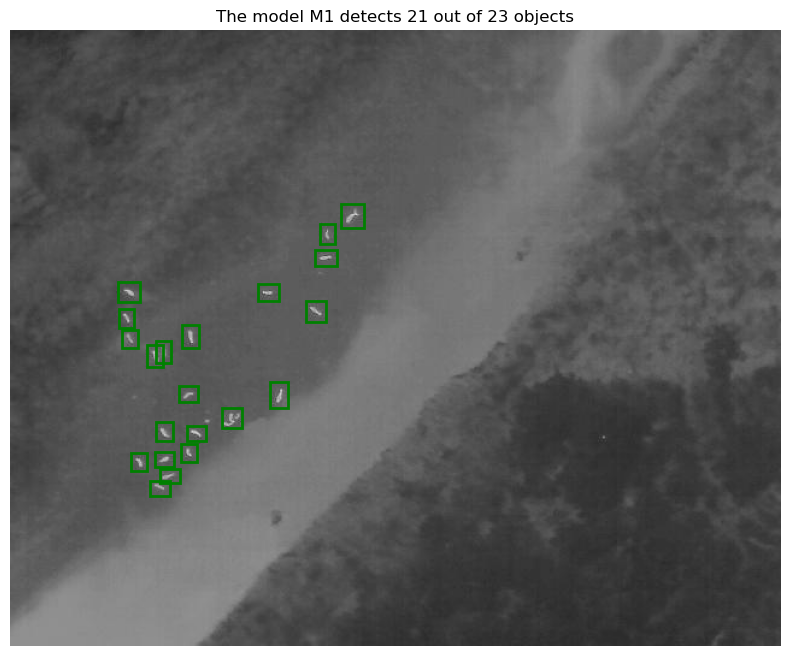

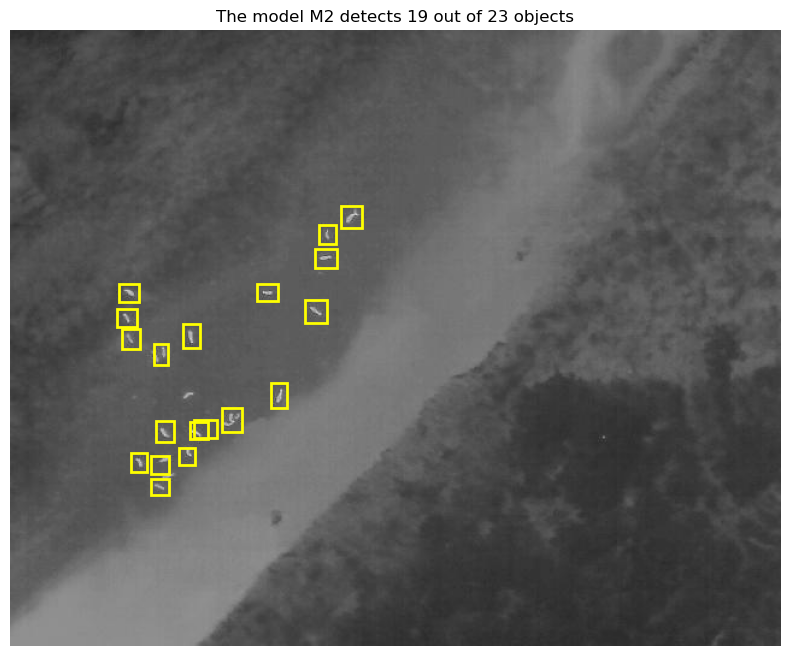

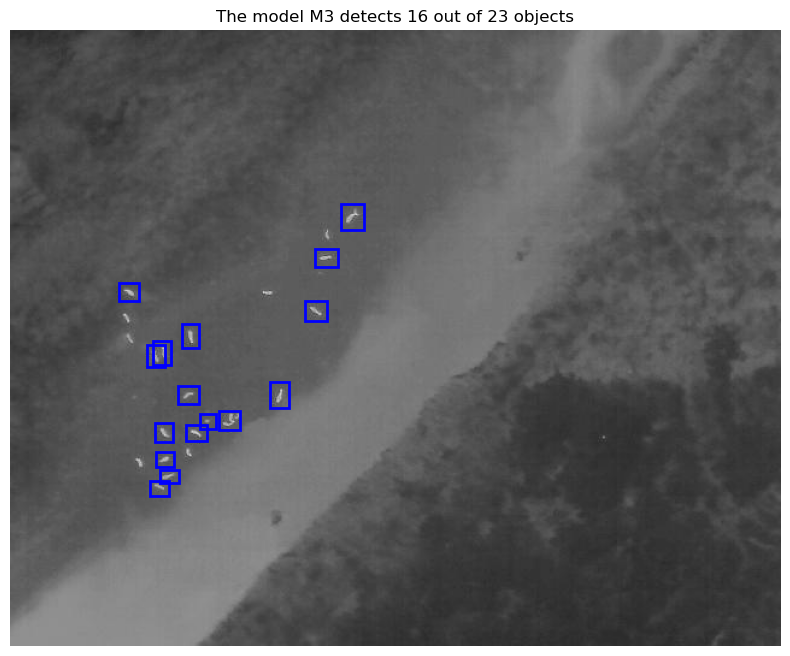

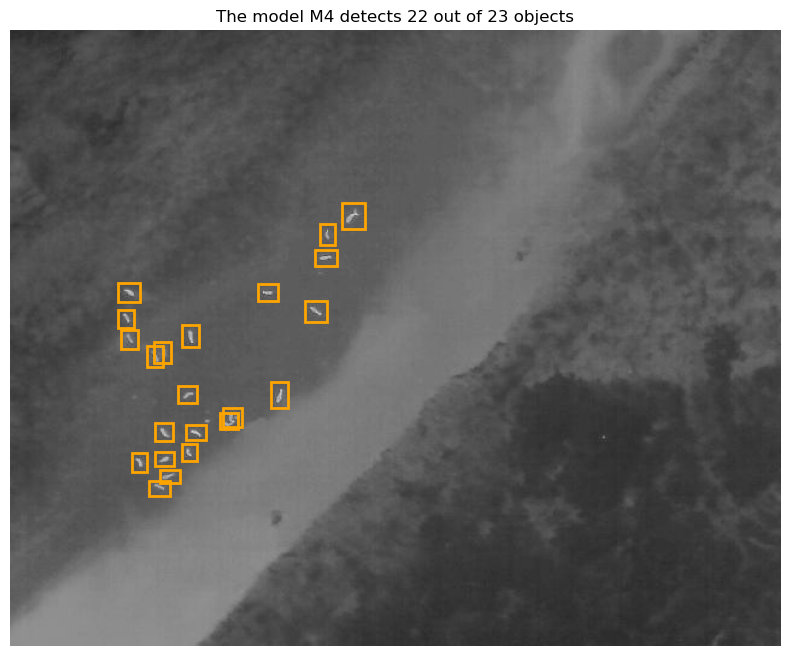

In [97]:
p = r'testImages/20.JPG'
img, pred = sodt_utils.smallObjDetection(M1,p)
boxes = pred['boxes']
boxes = boxes.detach().cpu().numpy()
img = img.numpy()
ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='green',figsize=(10,8))
ax.set_title(f'The model M1 detects {boxes.shape[0]} out of 23 objects')
ax.set_axis_off()
# M2
img, pred = sodt_utils.smallObjDetection(M2,p)
boxes = pred['boxes']
boxes = boxes.detach().cpu().numpy()
img = img.numpy()
ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='yellow',figsize=(10,8))
ax.set_title(f'The model M2 detects {boxes.shape[0]} out of 23 objects')
ax.set_axis_off()
# M3
img, pred = sodt_utils.smallObjDetection(M3,p)
boxes = pred['boxes']
boxes = boxes.detach().cpu().numpy()
img = img.numpy()
ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='blue',figsize=(10,8))
ax.set_title(f'The model M3 detects {boxes.shape[0]} out of 23 objects')
ax.set_axis_off()
#
img, pred = sodt_utils.smallObjDetection(M4,p)
boxes = pred['boxes']
boxes = boxes.detach().cpu().numpy()
img = img.numpy()
ax = sodt_utils.lht_vis_bbox(img*255,boxes,edgecolor='orange',figsize=(10,8))
ax.set_title(f'The model M4 detects {boxes.shape[0]} out of 23 objects')
ax.set_axis_off()